In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_07 import *

In [3]:
x_train,y_train,x_valid,y_valid = get_data()
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs))

In [4]:
nfs = [8,16,16]

## Momentum

### Base optimizer

In [5]:
class Optimizer(optim.Optimizer):
    def __init__(self, params, lr=0.4): super().__init__(params, dict(lr=lr))
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None: p.data.add_(-pg['lr'], self.get_step(pg, p))
                    
    def get_step(self, pg, p): return p.grad.data

In [6]:
def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight, a=0.1)

def get_runner(model, lr=0.6, cbs=None, loss_func = F.cross_entropy):
    opt = optim.SGD(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner([AvgStatsCallback([accuracy]), CudaCallback(),
        BatchTransformXCallback(resize_tfm(1,28,28))] + listify(cbs))

def get_learn_run(nfs, lr, cbs=None):
    model =  nn.Sequential(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
    init_cnn(model)
    return get_runner(model, lr=lr, cbs=cbs)

In [7]:
nfs = [8,16,32,32]

In [11]:
learn,run = get_learn_run(nfs, 0.8)

In [12]:
%time run.fit(1, learn)

train: [0.49268328125, tensor(0.8631, device='cuda:0')]
valid: [0.14789034423828126, tensor(0.9592, device='cuda:0')]
CPU times: user 829 ms, sys: 53.5 ms, total: 882 ms
Wall time: 882 ms


### Track grads

In [ ]:
class MomentumStats():
    def __init__(self, mom=0.9): self.mom,self.grad_avg = mom,None
    
    def update(self, grad):
        if self.grad_avg is None: self.grad_avg = grad.clone()
        else: self.grad_avg.mul_(self.mom).add_(grad)
        
class StatefulOptimizer(Optimizer):
    def __init__(self, params, stats_func, lr=0.4):
        super().__init__(params, lr=lr)
        self.stats_func = stats_func

    def get_state(self, p):
        if p not in self.state:
            # First time this param seen - create a stats obj for it and put it in `state`
            self.state[p] = self.stats_func()
        return self.state[p]
    
    def do_step(self, pg, p):
        # PyTorch will save anything stored in `state`; it's indexed by param
        stats = self.get_state(p)
        stats.update(p.grad.data)
        return stats.grad_avg

In [ ]:
model = get_cnn_model(data, nfs)
opt_func = partial(StatefulOptimizer, stats_func=MomentumStats)

In [ ]:
learn,run = get_runner(model, opt_func, 0.4, cbs=[CudaCallback(), BatchTransformXCallback(resize_tfm(1,28,28))])

In [ ]:
%time run.fit(3, learn)

train: [0.5633354296875, tensor(0.8796, device='cuda:0')]
valid: [0.19635775146484374, tensor(0.9558, device='cuda:0')]
train: [0.13952701171875, tensor(0.9684, device='cuda:0')]
valid: [0.10902095947265625, tensor(0.9729, device='cuda:0')]
train: [0.09538716796875, tensor(0.9769, device='cuda:0')]
valid: [0.092605859375, tensor(0.9757, device='cuda:0')]
CPU times: user 2.82 s, sys: 84 ms, total: 2.9 s
Wall time: 2.92 s


In [ ]:
#export
def to_np(x): return x.data.cpu().numpy()

# monkey patching to allow matplotlib to plot tensors
def tensor__array__(self, dtype=None):
    res = to_np(self)
    if dtype is None: return res
    else: return res.astype(dtype, copy=False)
torch.Tensor.__array__ = tensor__array__

In [ ]:
torch.Tensor.ndim = property(lambda x: len(x.shape))

AttributeError: 'Tensor' object has no attribute 'ndim'

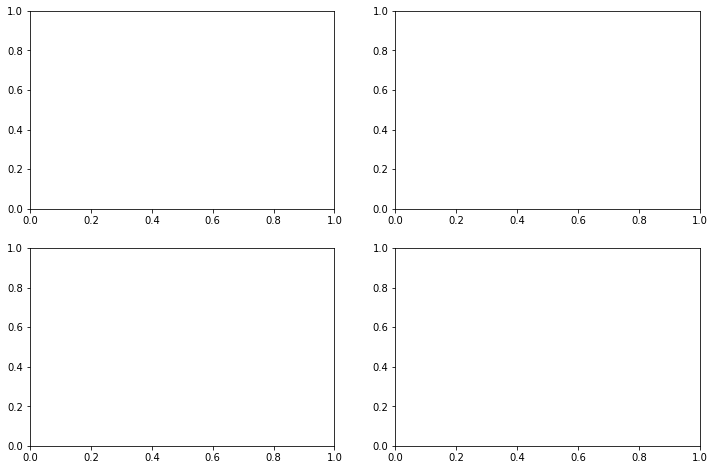

In [ ]:
x = torch.linspace(-4, 4, 100)
# y = 1 - (x/3) ** 2 + torch.randn(100) * 0.1
y = torch.randn(100) + 0.3
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.plot(y, linestyle='None', marker='.')
    avg,res = 0,[]
    for i,yi in enumerate(y):
        avg = beta * avg + yi
        res.append(avg)
    ax.plot(res, color='red')
    ax.set_title(f'beta={beta}')

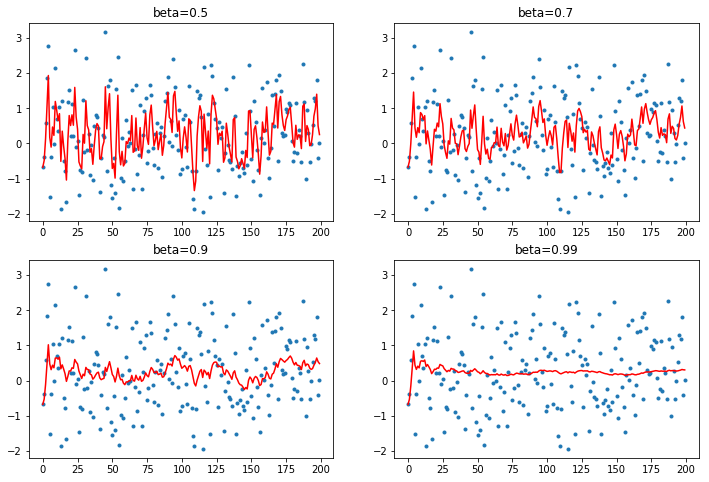

In [ ]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
# y = 1 - (x/3) ** 2 + torch.randn(100) * 0.1
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.plot(y, linestyle='None', marker='.')
    avg,res = 0,[]
    for i,yi in enumerate(y):
        avg = beta * avg + (1-beta) * yi
        res.append(avg/(1-beta**(i+1)))
    ax.plot(res, color='red');
    ax.set_title(f'beta={beta}')

In [ ]:
class WeightStats():
    def __init__(self, grad_mom=0, sqr_mom=0, grad_damp=None, sqr_damp=None):
        if grad_damp is None: grad_damp = 1-grad_mom
        if sqr_damp is None:  sqr_damp = 1-sqr_mom
        self.grad_mom,self.sqr_mom,self.grad_damp,self.sqr_damp = grad_mom,sqr_mom,grad_damp,sqr_damp
        self.grad_avg,self.sqr_avg = torch.zeros_like(p),torch.zeros_like(p)
    
    def update(self, grad):
        if self.grad_avg is None:
            self.grad_avg = grad.zeros_like()
            self.sqr_avg = grad*zeros_like()
            self.iter = 0

        self.iter += 1
        self.grad_avg.mul_(self.grad_mom).add_(self.grad_damp,grad)
        self.sqr_avg.mul_(self.sqr_mom).addcmul_(self.sqr_damp,grad,grad)
        # Above is the inplace version of this:
        # self.sqr_avg  = self.sqr_avg *self.sqr_mom  + (grad*grad)*self.sqr_damp

In [ ]:
model = get_cnn_model(data)
ws = partial(WeightStats, grad_mom=0.9, sqr_mom=0, grad_damp=1)
opt = Optimizer(model.parameters(), lr=0.1, stats=ws)
learn = Learner(model, opt, loss_func, data)
run = Runner([AvgStatsCallback([accuracy]), CudaCallback()])

In [ ]:
%time run.fit(3, learn)

train: [1.95824875, tensor(0.3316, device='cuda:0')]
valid: [0.59694013671875, tensor(0.8202, device='cuda:0')]
train: [0.3415712890625, tensor(0.8990, device='cuda:0')]
valid: [0.2184911376953125, tensor(0.9381, device='cuda:0')]
train: [0.1971289453125, tensor(0.9401, device='cuda:0')]
valid: [0.1510227294921875, tensor(0.9559, device='cuda:0')]
CPU times: user 1.97 s, sys: 80 ms, total: 2.05 s
Wall time: 2.04 s


## Refactor model

## Batchnorm

## Export

In [ ]:
!./notebook2script.py 05_more_callbacks.ipynb

Converted 05_more_callbacks.ipynb to nb_05.py
